In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Load the cleaned CSV exported in EDA notebook
# READY_FILE = '../data/loan_data_ready.csv'

READY_FILE = '../data/loan_data_ready_raw.csv'
df = pd.read_csv(READY_FILE)



In [2]:
# Define features & target from the ready CSV
target_col = 'not.fully.paid'

# Drop raw, untransformed features
# df = df.drop(columns=['days.with.cr.line', 'revol.bal'])

# pick up every remaining column except the target as a feature
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols]
y = df[target_col]

print("Features used:", feature_cols)
print("Target balance:\n", y.value_counts(normalize=True))






Features used: ['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'cr_line_years', 'pub_rec_flag', 'inquiry_rate', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_small_business']
Target balance:
 not.fully.paid
0    0.839946
1    0.160054
Name: proportion, dtype: float64


In [3]:
from sklearn.model_selection import train_test_split

# Use an 80/20 split, stratified on the target
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

print("Train target balance:\n", y_train.value_counts(normalize=True))
print("Test  target balance:\n", y_test.value_counts(normalize=True))





Train target balance:
 not.fully.paid
0    0.83999
1    0.16001
Name: proportion, dtype: float64
Test  target balance:
 not.fully.paid
0    0.83977
1    0.16023
Name: proportion, dtype: float64


In [4]:
# from imblearn.over_sampling import SMOTE
import numpy as np

# --- Commented out SMOTE to switch to class weights ---
# sm = SMOTE(random_state=42)
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Instead, use the original, imbalanced train data:
X_train_res = X_train.astype(np.float32)
y_train_res = y_train.astype(np.float32)
X_test      = X_test.astype(np.float32)
y_test      = y_test.astype(np.float32)

print("Using original train balance (no SMOTE):")
print(y_train_res.value_counts(normalize=True))





Using original train balance (no SMOTE):
not.fully.paid
0.0    0.83999
1.0    0.16001
Name: proportion, dtype: float64


In [5]:
from sklearn.utils import class_weight
import numpy as np

# Compute balanced class weights from the IMBALANCED y_train
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.values
)
class_weights = {0: weights[0], 1: weights[1]}
print("Class weights:", class_weights)


Class weights: {0: 0.5952454940957116, 1: 3.124796084828711}


In [7]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def make_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics= [keras.metrics.AUC(name='auc'),
                 keras.metrics.Recall(name='sensitivity')]
    )
    return model

input_dim = X_train_res.shape[1]
model     = make_model(input_dim)
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1280      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Re‐build a fresh model (new random weights)  
input_dim = X_train_res.shape[1]  
model     = make_model(input_dim)  
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1280      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [9]:
# history = model.fit(
#     X_train_res, y_train_res,  # old SMOTE‐resampled data
#     validation_split=0.2,
#     epochs=20,
#     batch_size=256
# )

# New: train using class weights on IMBALANCED data
history = model.fit(
    X_train_res,  # which is now X_train.astype(np.float32)
    y_train_res,  # which is now y_train.astype(np.float32)
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    class_weight=class_weights
)





Epoch 1/20


2025-06-02 16:06:03.279296: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


24/24 [==============================] - 0s 5ms/step - loss: 0.6985 - auc: 0.5659 - sensitivity: 0.5610 - val_loss: 0.6540 - val_auc: 0.6622 - val_sensitivity: 0.5489
Epoch 2/20
24/24 [==============================] - 0s 1ms/step - loss: 0.6722 - auc: 0.6395 - sensitivity: 0.5540 - val_loss: 0.6416 - val_auc: 0.6678 - val_sensitivity: 0.5872
Epoch 3/20
24/24 [==============================] - 0s 1ms/step - loss: 0.6701 - auc: 0.6472 - sensitivity: 0.6014 - val_loss: 0.6436 - val_auc: 0.6714 - val_sensitivity: 0.6128
Epoch 4/20
24/24 [==============================] - 0s 1ms/step - loss: 0.6680 - auc: 0.6517 - sensitivity: 0.6357 - val_loss: 0.6386 - val_auc: 0.6723 - val_sensitivity: 0.6128
Epoch 5/20
24/24 [==============================] - 0s 1ms/step - loss: 0.6616 - auc: 0.6654 - sensitivity: 0.6176 - val_loss: 0.6373 - val_auc: 0.6742 - val_sensitivity: 0.6000
Epoch 6/20
24/24 [==============================] - 0s 1ms/step - loss: 0.6647 - auc: 0.6552 - sensitivity: 0.6357 - val_

In [10]:
loss, auc, sensitivity = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss={loss:.4f}, AUC={auc:.4f}, Sensitivity={sensitivity:.4f}")



Test loss=0.6398, AUC=0.6874, Sensitivity=0.6938


In [11]:
from sklearn.metrics import accuracy_score

# predicted probabilities
y_pred_prob = model.predict(X_test)

# Convert to class labels using 0.5 cutoff
y_pred = (y_pred_prob >= 0.5).astype(int).reshape(-1)

# Compute accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}")


60/60 [==============================] - 0s 299us/step
Test accuracy: 0.5986


In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np

def metrics_at_thresh(y_true, y_prob, thresh):
    """
    Returns sensitivity (recall), specificity, and accuracy
    at a given probability threshold.
    """
    y_pred = (y_prob >= thresh).astype(int).reshape(-1)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy    = (tp + tn) / (tp + tn + fp + fn)
    return sensitivity, specificity, accuracy

print("Thresh  Sensitivity  Specificity  Accuracy")
for t in np.arange(0.1, 0.91, 0.05):
    sens, spec, acc = metrics_at_thresh(y_test, y_pred_prob, t)
    print(f"{t:5.2f}    {sens:10.3f}    {spec:10.3f}    {acc:8.3f}")


Thresh  Sensitivity  Specificity  Accuracy
 0.10         1.000         0.008       0.167
 0.15         0.997         0.049       0.201
 0.20         0.990         0.092       0.236
 0.25         0.974         0.146       0.279
 0.30         0.958         0.201       0.323
 0.35         0.925         0.267       0.372
 0.40         0.879         0.332       0.420
 0.45         0.818         0.423       0.486
 0.50         0.694         0.580       0.599
 0.55         0.485         0.740       0.699
 0.60         0.342         0.860       0.777
 0.65         0.231         0.931       0.819
 0.70         0.117         0.969       0.832
 0.75         0.055         0.987       0.838
 0.80         0.023         0.995       0.839
 0.85         0.013         0.998       0.840
 0.90         0.003         0.998       0.839


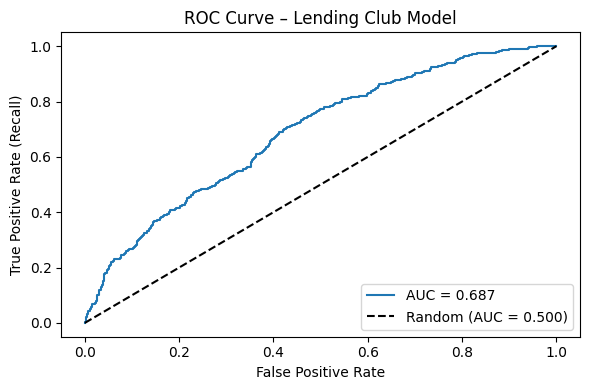

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Compute FPR, TPR, and thresholds for ROC
fpr, tpr, roc_thresh = roc_curve(y_test, y_pred_prob)
roc_auc_val = auc(fpr, tpr)

# 2. Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_val:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.500)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – Lending Club Model")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


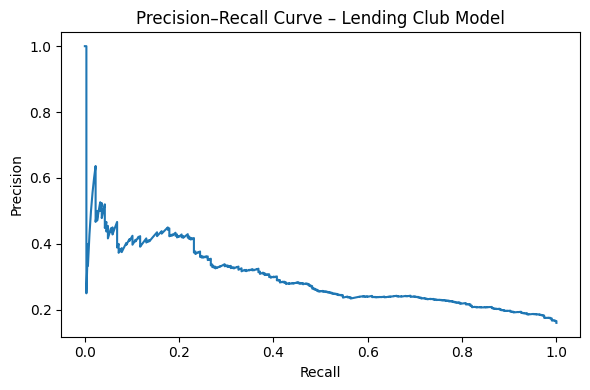

In [14]:
from sklearn.metrics import precision_recall_curve

# 1. Compute precision, recall, and thresholds
precision, recall, pr_thresh = precision_recall_curve(y_test, y_pred_prob)

# 2. Plot the PR curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Lending Club Model")
plt.tight_layout()
plt.show()
